In [13]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [15]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import MinVGGNet
##
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD

In [16]:
# get the arguments
#dataset_dir = r"C:\Users\mhasa\google_drive\PYTH\DeepLearning\DeepLearning-DL4CV\Edition3\ImageDataset\book2\flowers17\images"
dataset_dir = r"/content/drive/MyDrive/ImageDataset/book2/flowers17/images"


In [17]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(dataset_dir))
class_names = [path.split(os.path.sep)[-2] for path in image_paths]
class_names = [str(x) for x in np.unique(class_names)]

[INFO] loading images......


In [18]:
# init the preprocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset from disk, then scale
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths=image_paths,
                        verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [19]:
#partition the data into train test splits
trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                random_state=42,
                                                test_size=0.25)
# binarise the labels
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

In [20]:
# create augmentation generator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [21]:
print(f"[INFO] compiling the model......")
opt = SGD(learning_rate=0.05)
model = MinVGGNet.build(width=64,
                        height=64,
                        depth=3,
                        classes=len(class_names))
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling the model......


In [22]:
# train the network
print(f"[INFO] training network......")
if not aug:
    H = model.fit(trainx, trainy, validation_data=(testx, testy),
                  batch_size=32, epochs=100, verbose=1)
else:
    print("using generator")
    H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                            validation_data=(testx, testy),
                            steps_per_epoch=len(trainx)//32,
                            epochs=100,
                            verbose=1)

[INFO] training network......
using generator
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


31/31 [==============================] - 2s 47ms/step - loss: 3.4368 - accuracy: 0.2024 - val_loss: 3.0724 - val_accuracy: 0.1088
Epoch 2/100
31/31 [==============================] - 1s 40ms/step - loss: 2.3367 - accuracy: 0.3522 - val_loss: 2.5126 - val_accuracy: 0.2059
Epoch 3/100
31/31 [==============================] - 1s 39ms/step - loss: 2.0342 - accuracy: 0.4083 - val_loss: 2.9166 - val_accuracy: 0.1941
Epoch 4/100
31/31 [==============================] - 1s 40ms/step - loss: 1.7946 - accuracy: 0.4545 - val_loss: 2.7880 - val_accuracy: 0.2265
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 1.7100 - accuracy: 0.4808 - val_loss: 1.9842 - val_accuracy: 0.3647
Epoch 6/100
31/31 [==============================] - 1s 40ms/step - loss: 1.7337 - accuracy: 0.4808 - val_loss: 2.8235 - val_accuracy: 0.2382
Epoch 7/100
31/31 [==============================] - 1s 40ms/step - loss: 1.5789 - accuracy: 0.5283 - val_loss: 2.5137 - val_accuracy: 0.2412
Epoch 8/100
31/31 

In [23]:
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=class_names))

[INFO] evaluating network...
11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    bluebell       0.74      0.74      0.74        23
   buttercup       0.75      0.65      0.70        23
   coltsfoot       0.68      0.72      0.70        18
     cowslip       0.53      0.56      0.54        18
      crocus       0.40      0.75      0.52        16
    daffodil       0.89      0.36      0.52        22
       daisy       0.90      0.95      0.93        20
   dandelion       0.78      0.90      0.84        20
  fritillary       0.93      0.81      0.87        16
        iris       0.76      0.70      0.73        27
  lilyvalley       0.65      0.75      0.70        20
       pansy       0.82      0.86      0.84        21
    snowdrop       0.64      0.37      0.47        19
   sunflower       0.95      0.87      0.91        23
   tigerlily       0.90      0.95      0.93        20
       tulip       0.35      0.53      0.42        15

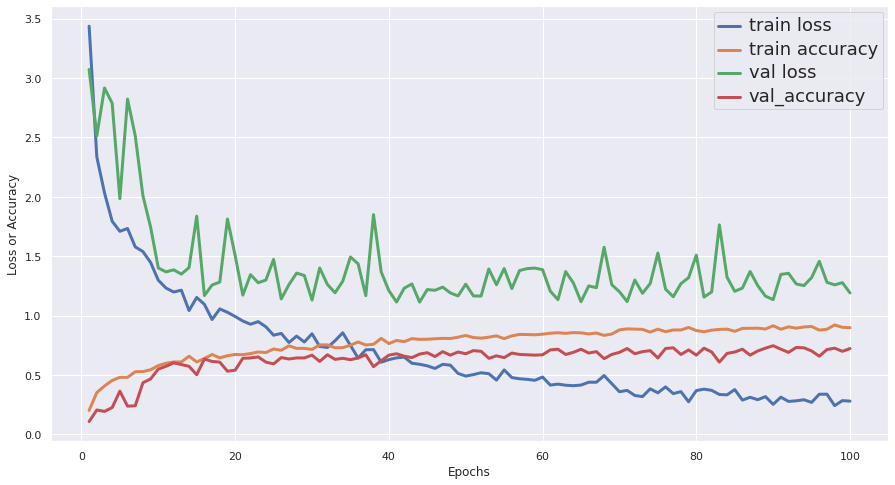

In [24]:
# plot the performance
epochs = range(1,101)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text